<a href="https://colab.research.google.com/github/GergelyTuri/sleep/blob/master/notebooks/attractor/DCA_analysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype notebook for toying with attractor models

based on Zhenrui's notebook.

* 3/13/2024 setup
* 3/14/2024 adding more efficient data loading, interactive plot and refined animation code (it is still slow tho)

In [1]:
!git clone https://github.com/GergelyTuri/sleep.git

Cloning into 'sleep'...
remote: Enumerating objects: 838, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 838 (delta 120), reused 101 (delta 47), pack-reused 625
Receiving objects: 100% (838/838), 15.00 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (482/482), done.


In [2]:
%cd sleep
!pip install .

/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1011 sha256=9f7f581a102e1b0d16d98790a39b5862d1c03b135f8b38d3b593a4d9933dbc80
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1hg6d6c/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [ ]:
# %cd sleep
# !git pull

In [3]:
!pip install git+https://github.com/BouchardLab/DynamicalComponentsAnalysis.git

  Cloning https://github.com/BouchardLab/DynamicalComponentsAnalysis.git to /tmp/pip-req-build-hyzvh0_l
  Running command git clone --filter=blob:none --quiet https://github.com/BouchardLab/DynamicalComponentsAnalysis.git /tmp/pip-req-build-hyzvh0_l
  Resolved https://github.com/BouchardLab/DynamicalComponentsAnalysis.git to commit d0636f7c11301667152504bdb93c5a88a50a1a68
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dca: filename=dca-1.0.0-py3-none-any.whl size=49880 sha256=75d55c8beaa379c93a7ea1c1fc499c309e4ec79c1cec7ad8a0dc819e6dabea83
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7zib090/wheels/7c/9c/cd/a3881e4b8fe80cdb8feeaadd85bceb2a98257ddceb09d6e92e
Successfully built dca


In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
from os.path import join
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(context="talk", style="ticks")
import sklearn
import os
from os.path import join
import scipy

from sleep.src import google_drive

# DCA
from dca import DynamicalComponentsAnalysis as DCA, style
from dca.cov_util import calc_cross_cov_mats_from_data
from dca.synth_data import embedded_lorenz_cross_cov_mats, gen_lorenz_data, random_basis, median_subspace
from dca.plotting.fig1 import lorenz_fig_axes, plot_3d, plot_lorenz_3d, plot_traces, plot_dca_demo, plot_r2, plot_cov

import plotly.graph_objects as go
import plotly.io as pio

In [6]:
useful_data = google_drive.useful_datasets()
useful_data

,mouseID,day,sessionID,cellType,trialID,behavior_file,significantCells,imaging_planes,sima folder,spectral plot,note
0,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_GC1-001,GC,747,,redo,1,TSeries-07072021-0833_GC1-001_Cycle00001_Eleme...,done,S/N is not so great
1,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_GC2-003,GC,745,5ht2afl05b_1_20210707120714_745_sleep.json,redo,1,TSeries-07072021-0833_GC2-003_Cycle00001_Eleme...,done,"looks good, uploaded"
2,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_MC1-002,MC,740,5ht2afl05b_1_20210707110302_740_sleep.json,redo,1,TSeries-07072021-0833_MC1-002_Cycle00001_Eleme...,done,
3,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_MC2-004,MC,749,5ht2afl05b_1_20210707131056_749_sleep.json,redo,1,TSeries-07072021-0833_MC2-004_Cycle00001_Eleme...,done,nice
4,5HT2afl05b_1,7_12_SD2,TSeries-07122021-0901-002,GC_MC,,,,2,,,
5,5HT2afl05b_2,7_6_SD,TSeries-07062021-0844_GC-001,GC,762,5ht2afl05b_2_20210706101536_762_sleep.json,redo,1,TSeries-07062021-0844_GC-001_Cycle00001_Elemen...,done,S/N is not so great
6,5HT2afl05b_2,7_6_SD,TSeries-07062021-0844_MC-002,MC,761,5ht2afl05b_2_20210706112012_761_sleep.json,redo,1,TSeries-07062021-0844_MC-002_Cycle00001_Elemen...,done,looks good
7,5HT2afl05b_2,7_6_SD,TSeries-07062021-0844_MC2-004,MC,760,5ht2afl05b_2_20210706133302_760_sleep.json,redo,1,TSeries-07062021-0844_MC2-004_Cycle00001_Eleme...,done,"best, uploaded"
8,126031_5,11_23,TSeries-11232022-GC-GC-001,GC,874,126031_5_20221123154956_874_sleep.json,,2,TSeries-11232022-GC-GC-001.sima,,looks very good.
9,126031_5,11_23,TSeries-11232022-GC-MC-002,GC,876,126031_5_20221123163346_876_sleep.json,redo,2,TSeries-11232022-GC-MC-002.sima,,"very nice 2p, but ca signal craps off after ab..."


In [7]:
in_row = 6
exp_path = google_drive.return_exp_path(useful_data.iloc[in_row]['mouseID'], useful_data.iloc[in_row]['day'], useful_data.iloc[in_row]['sessionID'])
exp_path

'/gdrive/Shareddrives/Turi_lab/Data/Sleep/2p/Analysis/data/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002'

In [8]:
dfof = pd.read_csv(join(exp_path, "dfof.csv"))
dfof = dfof.set_index("roi_label")

In [9]:
velo_eeg = pd.read_csv(join(exp_path, 'eeg', "velo_eeg.csv"))

In [10]:
dfof.head(3)

,0,1,2,3,4,5,6,7,8,9,...,35990,35991,35992,35993,35994,35995,35996,35997,35998,35999
roi_label,,,,,,,,,,,,,,,,,,,,,
0000-0241-0158,0.249892,0.227246,0.183762,0.339452,0.511559,0.385360,0.377524,0.237826,0.353179,0.486433,...,-0.034746,0.093191,-0.120473,-0.006356,-0.098687,-0.044679,-0.050351,-0.021662,0.040089,-0.050446
0000-0214-0206,0.488423,0.256443,0.277518,0.043772,0.232232,0.235971,0.041588,0.480784,0.094628,0.347735,...,0.002035,0.128184,0.106252,0.305982,0.193522,0.244586,0.255288,0.290784,0.145599,0.557197
0000-0185-0141,0.452710,0.126225,0.203884,0.148358,0.179435,0.066239,0.055071,-0.074595,0.141502,0.071339,...,1.726147,2.142220,1.805656,2.187768,2.103489,2.128277,1.903861,2.313566,2.081483,2.102961


In [11]:
dfof.shape, velo_eeg.shape

((49, 36000), (36000, 5))

In [12]:
dfof.T.iloc[:20000]

roi_label,0000-0241-0158,0000-0214-0206,0000-0185-0141,0000-0272-0082,0000-0192-0214,0000-0332-0371,0000-0326-0393,0000-0271-0146,0000-0247-0321,0000-0341-0233,...,0000-0277-0436,0000-0193-0241,0000-0317-0297,0000-0272-0293,0000-0216-0251,0000-0177-0101,0000-0397-0285,0000-0406-0315,0000-0374-0170,0000-0240-0184
0,0.249892,0.488423,0.452710,0.218065,0.532859,0.469296,0.233774,0.275872,0.037867,-0.008521,...,-0.014615,0.658229,0.245329,0.080378,0.327324,-0.010498,0.529604,0.202209,0.002006,0.256447
1,0.227246,0.256443,0.126225,0.066999,0.280972,0.557397,0.345808,0.618313,0.091899,-0.140055,...,-0.161734,0.484612,0.123346,0.385406,-0.053028,0.300979,0.995363,0.742421,0.100347,0.106383
2,0.183762,0.277518,0.203884,0.022383,0.346813,0.297332,0.513599,0.536679,-0.008859,0.117513,...,0.040113,0.598148,0.138349,0.246155,0.176305,0.325767,0.312103,-0.285977,0.005371,-0.057808
3,0.339452,0.043772,0.148358,-0.124661,0.145047,0.443984,0.273275,0.805766,0.164662,0.166826,...,-0.125836,0.636856,0.062668,0.133215,0.332871,0.250629,0.359341,0.550754,-0.041637,0.099124
4,0.511559,0.232232,0.179435,-0.065459,-0.033096,0.192667,0.221689,0.412028,-0.073117,0.181212,...,0.120811,0.419925,0.208067,-0.130331,0.065357,-0.077635,0.458529,0.170119,0.421494,0.214634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.336250,0.490337,0.119792,0.100083,0.472209,0.302588,0.039674,0.423034,0.520921,0.119434,...,0.060280,0.401619,0.337426,0.097992,-0.142380,0.204291,0.372682,-0.017886,0.418139,0.109963
19996,0.449843,0.372754,0.145069,0.078473,0.538395,0.226566,0.302173,0.104140,0.343211,0.145834,...,-0.103856,0.491092,0.174443,0.255843,0.248286,0.296934,0.276862,0.447764,0.221012,-0.234904
19997,0.338395,0.399501,0.100107,0.118692,0.611800,0.121444,0.524687,0.284129,0.307692,0.340398,...,-0.212010,0.143907,0.337400,0.007971,0.295431,0.230507,-0.337203,0.097034,-0.076935,0.036621
19998,0.299769,0.766449,0.181284,0.322104,0.492452,0.229603,0.474243,-0.077725,0.310393,0.279091,...,0.217103,0.240614,0.218984,0.154195,0.151691,0.376577,0.617571,0.430642,-0.049140,0.043147


In [13]:
#Run DCA
opt = DCA(T=10, d=2)
opt.fit(np.asarray(dfof.T))
V_dca = opt.coef_

#Project data onto DCA and PCA bases
X_dca = np.dot(np.asarray(dfof.T), V_dca)


In [14]:
X_roll = dfof.T.rolling(10).mean().dropna()

In [15]:
opt_roll = DCA(T=10, d=2)
opt_roll.fit(np.asarray(X_roll))
V_dca = opt_roll.coef_

In [16]:
Xroll_dca = np.dot(np.asarray(X_roll), V_dca)


In [17]:
opt_3 = DCA(T=10, d=3)
opt_3.fit(np.asarray(X_roll))
V_dca3 = opt_3.coef_
X_dca3 = np.dot(np.asarray(X_roll), V_dca3)


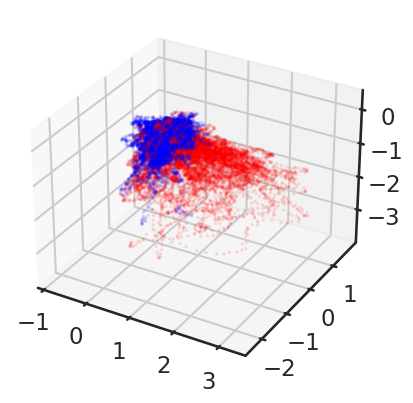

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_dca3[:, 0], X_dca3[:, 1], X_dca3[:, 2], c=velo_eeg['awake'].iloc[9:], cmap='bwr', s=1,alpha=0.1)
fig.savefig(join(exp_path, 'dca_3d.png'), dpi=300)

In [19]:
# Convert boolean array to numeric values: True to 1, False to 0
color_data_numeric = np.where(velo_eeg['awake'].iloc[9:], 1, 0)

fig = go.Figure(data=[go.Scatter3d(
    x=X_dca3[:, 0],
    y=X_dca3[:, 1],
    z=X_dca3[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=color_data_numeric,  # Numeric values for colorscale
        colorscale='RdBu',  # Choosing a diverging colorscale for binary data
        colorbar=dict(title='Awake State'),
        opacity=0.1
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='X AXIS TITLE',
                    yaxis_title='Y AXIS TITLE',
                    zaxis_title='Z AXIS TITLE'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))
fig.write_html(join(exp_path, 'interactive_plot.html'))
fig.show()

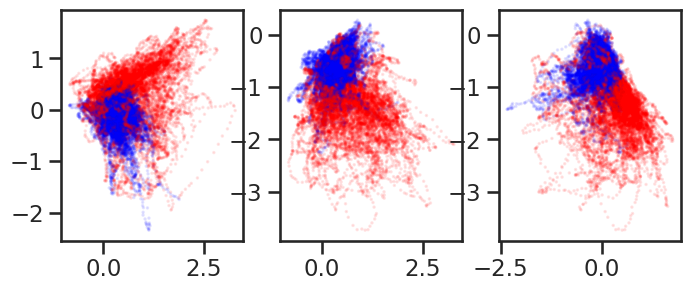

In [20]:
#plt.plot(X_dca[:,0], X_dca[:,1],lw=0.1, c='k')
fig, axes = plt.subplots(1,3,figsize=(8,3))
axes[0].scatter(X_dca3[:,0], X_dca3[:,1],c=velo_eeg['awake'][9:], cmap='bwr',alpha=0.1,s=1)
axes[1].scatter(X_dca3[:,0], X_dca3[:,2],c=velo_eeg['awake'][9:], cmap='bwr',alpha=0.1,s=1)
axes[2].scatter(X_dca3[:,1], X_dca3[:,2],c=velo_eeg['awake'][9:], cmap='bwr',alpha=0.1,s=1)
fig.savefig(join(exp_path, 'dcas.png'), dpi=300)

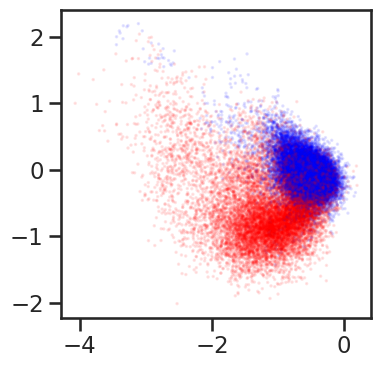

In [21]:
#plt.plot(X_dca[:,0], X_dca[:,1],lw=0.1, c='k')
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X_dca[:,0], X_dca[:,1],c=velo_eeg['awake'], cmap='bwr',alpha=0.1,s=1)
fig.savefig(join(exp_path, 'dca_scatter.png'), dpi=300)

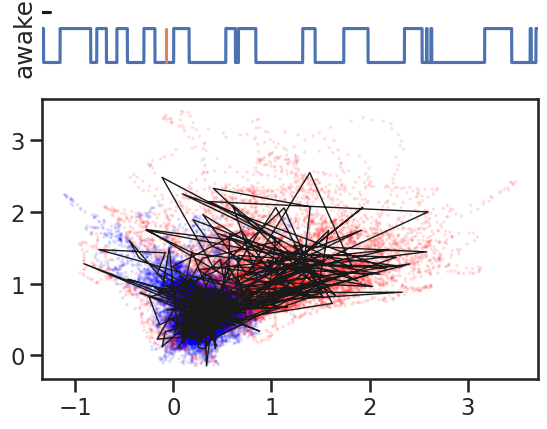

In [22]:
#plt.plot(X_dca[:,0], X_dca[:,1],lw=0.1, c='k')
fig, (ax_state, ax_scatter) = plt.subplots(2,1,gridspec_kw={"height_ratios":[1,5]})
#axes[0].plot(X_dca[:,0], X_dca[:,1],lw=0.1)
ax_state.plot(velo_eeg['awake'].iloc[9:])
sns.despine(ax=ax_state, left=True, bottom=True)
ax_state.set_xlim([9,len(Xroll_dca)])
ax_state.plot([9,9+600],[1.5,1.5],color='k')
ax_state.set_xticks([])
ax_state.set_yticks([])
ax_state.set_ylabel("awake")

line, = ax_state.plot([900, 900], [0,1])
line.set_data([9000, 9000], [0,1])

ax_scatter.scatter(Xroll_dca[:,0], Xroll_dca[:,1],c=velo_eeg['awake'].iloc[9:], cmap='bwr',alpha=0.1,s=1)
ax_scatter.plot(Xroll_dca[::100,0], Xroll_dca[::100,1],lw=1, c='k')

fig.savefig(join(exp_path, 'composit.png'), dpi=300)

## Animation (slow)

In [ ]:
fig, (ax_state, ax_scatter) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [1, 5]})

def init(Xroll_dca, velo_eeg):
    ln_state, = ax_state.plot([9, 9], [0, 1], lw=2)
    ax_state.plot(velo_eeg['awake'].iloc[9:], alpha=0.5)
    sns.despine(ax=ax_state, left=True, bottom=True)
    ax_state.set_xlim([9, len(Xroll_dca)])
    ax_state.plot([9, 9+600], [1.5, 1.5], color='k')
    ax_state.set_xticks([])
    ax_state.set_yticks([])
    ax_state.set_ylabel("awake")

    ax_scatter.scatter(Xroll_dca[:, 0], Xroll_dca[:, 1], c=velo_eeg['awake'].iloc[9:], cmap='bwr', alpha=0.1, s=1)
    ln_scatter, = ax_scatter.plot([], [], 'k-', lw=1)

    return [ln_state, ln_scatter], ax_state, ax_scatter

def update(frame, Xroll_dca, line, xdata, ydata):
    x, y = Xroll_dca[frame]  # frame
    if len(xdata) >= 8:  # Keep the last 8 points only
        xdata.pop(0)
        ydata.pop(0)
    xdata.append(x)
    ydata.append(y)
    line[1].set_data(xdata, ydata)
    line[0].set_data([frame, frame], [0, 1])
    return line

# Initialize the figure
line, ax_state, ax_scatter = init(Xroll_dca, velo_eeg)
xdata, ydata = [], []

# Animation
ani = FuncAnimation(fig, lambda frame: update(frame, Xroll_dca, line, xdata, ydata), frames=np.arange(0, len(Xroll_dca[9:]), 100), init_func=lambda: init(Xroll_dca, velo_eeg)[0], blit=True)

# Saving
writervideo = FFMpegWriter(fps=6)
ani.save(join(exp_path, 'dynamics.mp4'), writer=writervideo)

plt.close()
